In [12]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Activation, add
import tensorflow as tf

In [13]:
train_path ='land_dataset/train/'
test_path = 'land_dataset/test/'
train_batches = ImageDataGenerator(validation_split=0.1) \
                .flow_from_directory(directory=train_path,  
                                     classes = ['land','not_land'], 
                                     subset='training',
                                     batch_size=10)

validation_batches = ImageDataGenerator(validation_split=0.1) \
                     .flow_from_directory(directory=train_path, 
                                          classes = ['land', 'not_land'], 
                                          subset='validation',
                                          batch_size=10)
                
test_batches = ImageDataGenerator() \
                    .flow_from_directory(directory=test_path, 
                                        classes = ['land', 'not_land'], 
                                         batch_size=10, 
                                         shuffle=False)

Found 19607 images belonging to 2 classes.
Found 2178 images belonging to 2 classes.
Found 2421 images belonging to 2 classes.


In [14]:
IMG_SIZE = 100
n_classes = 2

inp = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x1 = layers.Resizing(IMG_SIZE, IMG_SIZE)(inp)
x2 = layers.Rescaling(1./255)(x1)
x3 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                   padding = 'same', input_shape=(IMG_SIZE,IMG_SIZE,3))(x2)
x5 = layers.BatchNormalization(axis=-1)(x3)
x6 = layers.MaxPool2D(pool_size=(2, 2))(x5)
x7 = layers.Conv2D(filters=64, kernel_size=(3, 3), 
                   activation='relu', padding = 'same')(x6)
x9 = layers.BatchNormalization(axis=-1)(x7)
x10 = layers.MaxPool2D(pool_size=(2, 2))(x9)

x11 = layers.Conv2D(filters=128, kernel_size=(3, 3), 
                    activation='relu', padding = 'same')(x10)
x13 = layers.BatchNormalization(axis=-1)(x11)
x14 = layers.MaxPool2D(pool_size=(2, 2))(x13)
x15 = layers.Conv2D(filters=256, kernel_size=(3, 3), 
                      activation='relu', padding = 'same')(x14)
x17 = layers.BatchNormalization(axis=-1)(x15)
x18 = layers.MaxPool2D(pool_size=(2, 2))(x17)
y1 = layers.Flatten()(x18)
y2 = layers.Dense(300, activation='relu')(y1)
y3 = layers.Dense(150, activation='relu')(y2)
y4 = layers.Dropout(0.25)(y3)
y = layers.Dense(n_classes, activation='softmax')(y4)   

model = keras.Model(inp,y)

In [15]:
EPOCHS = 10
BATCH_SIZE = 8
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics='accuracy')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 resizing_1 (Resizing)       (None, 100, 100, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                       

In [16]:
history = model.fit(x=train_batches,
                            validation_data=validation_batches,
                            steps_per_epoch=len(train_batches),
                            validation_steps=len(validation_batches),
                            epochs=5,
                            batch_size=BATCH_SIZE, 
                            verbose=1)

Epoch 1/5


2024-06-03 07:15:15.394058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1961/1961 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9859

2024-06-03 07:19:24.827466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1961/1961 [==============================] - 258s 131ms/step - loss: 0.0580 - accuracy: 0.9859 - val_loss: 0.0399 - val_accuracy: 0.9894
Epoch 2/5
1961/1961 [==============================] - 250s 127ms/step - loss: 0.0330 - accuracy: 0.9917 - val_loss: 0.0331 - val_accuracy: 0.9867
Epoch 3/5
1961/1961 [==============================] - 258s 131ms/step - loss: 0.0354 - accuracy: 0.9919 - val_loss: 0.0235 - val_accuracy: 0.9908
Epoch 4/5
1961/1961 [==============================] - 230s 118ms/step - loss: 0.0207 - accuracy: 0.9941 - val_loss: 0.0283 - val_accuracy: 0.9899
Epoch 5/5
1961/1961 [==============================] - 237s 121ms/step - loss: 0.0203 - accuracy: 0.9954 - val_loss: 0.0313 - val_accuracy: 0.9917


In [9]:
model.save('land_model.h5')

In [10]:
loss_and_metrics = model.evaluate(test_batches, batch_size=BATCH_SIZE, verbose=1)

  7/243 [..............................] - ETA: 5s - loss: 0.0000e+00 - accuracy: 1.0000

2024-06-03 06:18:42.529060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


243/243 [==============================] - 5s 21ms/step - loss: 0.0085 - accuracy: 0.9971


  4/243 [..............................] - ETA: 5s 

2024-06-03 06:19:11.859095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


243/243 [==============================] - 5s 20ms/step


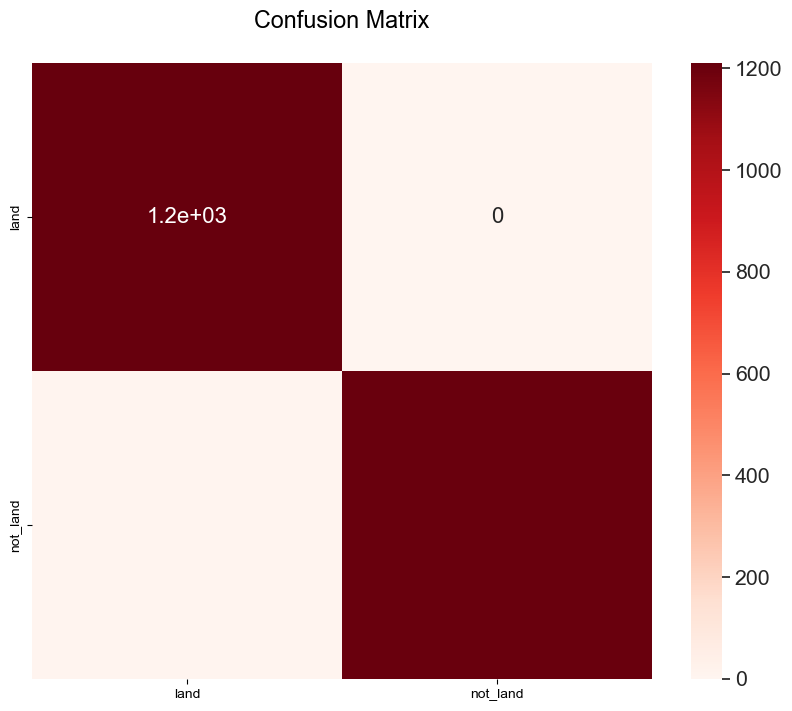

Classification Report

              precision    recall  f1-score   support

        land       0.99      1.00      1.00      1211
    not_land       1.00      0.99      1.00      1210

    accuracy                           1.00      2421
   macro avg       1.00      1.00      1.00      2421
weighted avg       1.00      1.00      1.00      2421



In [11]:
num_classes = len(train_batches.class_indices)  
train_labels = train_batches.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = validation_batches.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_batches.filenames)  
nb_valid_samples = len(validation_batches.filenames)
nb_test_samples = len(test_batches.filenames)
Y_pred = model.predict(test_batches, nb_test_samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_batches.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_batches.class_indices.keys()), list(test_batches.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Reds)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report\n')
target_names = list(test_batches.class_indices.keys())
print(classification_report(test_batches.classes, y_pred, target_names=target_names))